<a href="https://colab.research.google.com/github/sanhariharan/FINETUNING-google-flan-t5-With-LORA/blob/main/LORA_FINETUNING_FLAN_T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers tensorflow datasets tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
dataset=load_dataset('wmt16','de-en')
print(dataset['train'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/282M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/267M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/277M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/343k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/475k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4548885 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2169 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2999 [00:00<?, ? examples/s]

{'translation': {'de': 'Wiederaufnahme der Sitzungsperiode', 'en': 'Resumption of the session'}}


In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')

# Preprocessing function
def preprocess_data(examples):
    inputs = [f'Translate English to German: {example["en"]}' for example in examples['translation']]
    targets = [example['de'] for example in examples['translation']]

    # Tokenize the inputs
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding='max_length', return_tensors='tf')

    # Tokenize the targets
    labels = tokenizer(targets, max_length=128, truncation=True, padding='max_length', return_tensors='tf').input_ids
    model_inputs['labels'] = labels

    # Add decoder input ids (optional for some architectures)
    decoder_inputs = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["decoder_input_ids"] = decoder_inputs["input_ids"]

    return model_inputs

# Process the training and testing datasets
train_dataset = dataset['train'].select(range(2000)).map(preprocess_data, batched=True)
test_dataset = dataset['test'].select(range(1000)).map(preprocess_data, batched=True)

# Convert to TensorFlow datasets
train_dataset = train_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'decoder_input_ids'],  # Corrected 'columns'
    label_cols=['labels'],
    batch_size=8,
    shuffle=True,
    collate_fn=None
)

test_dataset = test_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'decoder_input_ids'],  # Corrected 'columns'
    label_cols=['labels'],
    batch_size=8,
    shuffle=False,
    collate_fn=None
)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [ ]:
from transformers import TFAutoModelForSeq2SeqLM,AutoTokenizer

from tensorflow.keras.layers import Dense
# Initialize the model
model = TFAutoModelForSeq2SeqLM.from_pretrained('google/flan-t5-small')

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSeq2SeqLM, AutoTokenizer
from tensorflow.keras.layers import Dense

# Define LoRA Layer
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, dense, rank=4):
        super().__init__()
        self.dense = dense
        self.rank = rank

    def build(self, input_shape):
        self.W_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                   initializer='random_normal', trainable=True, name='w_a')
        self.W_b = self.add_weight(shape=(self.rank, self.dense.units),
                                   initializer='random_normal', trainable=True, name='w_b')

    def call(self, inputs):
        original_output = self.dense(inputs)
        lora_output = tf.matmul(tf.matmul(inputs, self.W_a), self.W_b)
        self.dense.trainable = False

        return original_output + lora_output

# Load Pre-trained FLAN-T5 model and tokenizer
model_name = 'google/flan-t5-small'
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)




All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [ ]:
model.summary()

Model: "tft5_for_conditional_generation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35332800  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41628352  
                                                                 
 lm_head (Dense)             multiple                  16449536  
                                                                 
Total params: 76961152 (293.58 MB)
Trainable params: 76961152 (293.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
[layer for layer in model.decoder._flatten_layers()]

In [ ]:
import tf_keras
for ix,layer in enumerate(model.decoder._flatten_layers()):
  if isinstance(layer,tf_keras.src.layers.core.dense.Dense):
    layer.trainable=False
    layer=LoRALayer(layer)
  else:
    layer.trainable=False
model.get_layer('encoder').trainable=False
model.get_layer('shared').trainable=False
model.layers[3]= LoRALayer(model.get_layer('lm_head'))


In [ ]:
model.summary()

Model: "tft5_for_conditional_generation_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35332800  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41628352  
                                                                 
 lm_head (Dense)             multiple                  16449536  
                                                                 
Total params: 76961152 (293.58 MB)
Trainable params: 16449536 (62.75 MB)
Non-trainable params: 60511616 (230.83 MB)
_________________________________________________________________


In [ ]:
#Evaluation of the Model
model.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=1e-3))
model.fit(train_dataset, validation_data=test_dataset,epochs=3)

Epoch 1/3
250/250 [==============================] - 62s 151ms/step - loss: 27.2585 - val_loss: 23.3500
Epoch 2/3
250/250 [==============================] - 34s 135ms/step - loss: 18.0630 - val_loss: 13.7353
Epoch 3/3
250/250 [==============================] - 34s 137ms/step - loss: 9.4096 - val_loss: 4.5245


In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')

# Example input text (English sentence)
input_text = "Translate English to German: How are you today?"

# Tokenize input
inputs = tokenizer(input_text, return_tensors="tf", padding=True, truncation=True)


In [ ]:
# Generate translation
outputs = model.generate(**inputs)

# Decode the output tokens to get the translated text
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print the translation
print("Translated Text:", translated_text)


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:837: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length.  recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Translated Text: Wie sind wir heute heute heute?


In [ ]:
# List of input sentences in German with simpler prompt
input_sentences = [
    "Translate German to English: Ich liebe maschinelles Lernen.",
    "Translate German to English: Das Wetter ist heute schön.",
    "Translate German to English: Wo ist der nächste Bahnhof?"
]

# Tokenize the batch of sentences
batch_inputs = tokenizer(input_sentences, return_tensors="tf", padding=True, truncation=True)

# Generate translations with adjusted decoding parameters
batch_outputs = model.generate(**batch_inputs, max_length=50, num_beams=5, early_stopping=True)

# Decode each output into human-readable English text
translated_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in batch_outputs]

# Print translations
for i, translation in enumerate(translated_texts):
    print(f"Input (German): {input_sentences[i]}")
    print(f"Translated (English): {translation}")
    print()


Input (German): Translate German to English: Ich liebe maschinelles Lernen.
Translated (English): I love machine learning.

Input (German): Translate German to English: Das Wetter ist heute schön.
Translated (English): The best time of the day for us is today.

Input (German): Translate German to English: Wo ist der nächste Bahnhof?
Translated (English): How is the nächste Bahnhof?



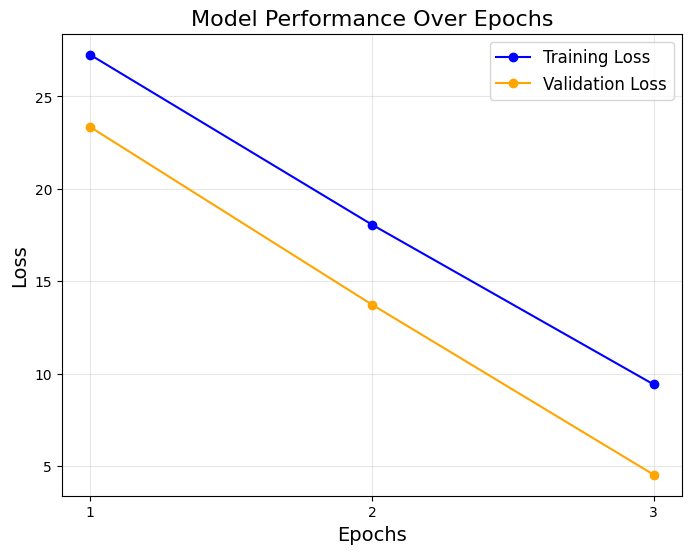

In [ ]:
import matplotlib.pyplot as plt

# Data from the training process
epochs = [1, 2, 3]
training_loss = [27.2585, 18.0630, 9.4096]
validation_loss = [23.3500, 13.7353, 4.5245]

# Plotting the losses
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', color='blue')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o', color='orange')

# Adding titles and labels
plt.title('Model Performance Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(epochs)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Display the plot
plt.show()
